In [6]:
import pandas as pd

In [7]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [8]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [9]:
scores = scores[(scores != 0).all(1)]

In [10]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [11]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [33]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

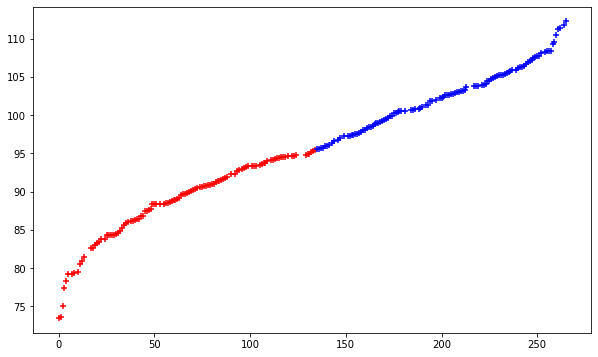

In [42]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
color = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=color, marker='+')

In [46]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

pd.concat([a.head(), b.head()])

abc
